In [37]:
import numpy as np
from tqdm import tqdm

from scipy.sparse import coo_matrix

%matplotlib inline
import matplotlib.pyplot as plt

from sgimc.utils import sparsify, sparsify_with_mask

from sgimc import IMCProblem

from sgimc.qa_objective import QAObjectiveL2Loss
from sgimc.qa_objective import QAObjectiveLogLoss
from sgimc.qa_objective import QAObjectiveHuberLoss

from sgimc.algorithm.admm import sub_0_cg
from sgimc.algorithm.admm import sub_0_lbfgs
from sgimc.algorithm.admm import sub_m

from sgimc import imc_descent
from sgimc.utils import performance

from sgimc.utils import plot_WH, plot_loss

from utils import calculate_loss, invert, accuracy, get_prediction

PROBLEM = "classification" if True else "regression"
random_state = np.random.RandomState(0x0BADCAFE)

In [2]:
from sgimc.algorithm import admm_step
from sgimc.algorithm.decoupled import step as decoupled_step

def step_qaadmm(problem, W, H, C, eta, method="l-bfgs", sparse=True,
                n_iterations=50, rtol=1e-5, atol=1e-8):

    approx_type = "quadratic" if method in ("cg","tron",) else "linear"
    Obj = problem.objective(W, H, approx_type=approx_type)

    return admm_step(Obj, W, C, eta, sparse=sparse, method=method,
                     n_iterations=n_iterations, rtol=rtol, atol=atol)

def step_decoupled(problem, W, H, C, eta, rtol=1e-5, atol=1e-8):

    Obj = problem.objective(W, H, approx_type="linear")

    return decoupled_step(Obj, W, C, eta, rtol=rtol, atol=atol)

In [3]:
step_fn = step_qaadmm
# step_fn = step_decoupled

In [4]:
if PROBLEM == "classification":
    QAObjectiveLoss = QAObjectiveLogLoss
else:
    QAObjectiveLoss = QAObjectiveL2Loss  # QAObjectiveHuberLoss

In [18]:
C_ridge = 1e-4
Cs_group = [2e-1, 2e-4]
eta = 1e0

## Parameter to vary

In [6]:
elements = [0.0005, 0.001, 0.002, 0.003, 0.005, 0.006, 0.008, 0.01]

## Data loading

In [7]:
exp_path = '/nmnt/x04-hdd/boris_temp/SGIMC_IMC/covtype/'
R_full = np.load(exp_path + 'R.npy')
X = np.load(exp_path + 'X.npy')

Y = np.eye(len(R_full))
y_mask = np.array(Y, dtype='bool')
Y = sparsify_with_mask(Y, y_mask)

## K = 5

In [8]:
K = 5 # K = X.shape[1]
n_iter = 100

In [9]:
accs = []
for n in tqdm(elements):
    R_train, mask = sparsify(R_full, n, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X, Y, R_train, n_threads=8)

    C_accuracies = []
    for C_group in Cs_group:
        C_lasso = 10 * C_group
        C = (C_lasso, C_group, C_ridge)
        step_kwargs = {
            "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
            "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
            "rtol": 1e-2,           # the relative tolerance for stopping the ADMM
            "atol": 1e-4,           # the absolute tolerance
            "method": "tron",       # the method to use in Sub_0
            "n_iterations": 2,      # the number of iterations of the inner ADMM
        }
        
        W_0 = random_state.normal(size=(X.shape[1], K))
        H_0 = random_state.normal(size=(Y.shape[1], K))

        W, H = W_0.copy(), H_0.copy()
        
        W, H = imc_descent(problem, W, H,
                           step_fn,                  # the inner optimization
                           step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                           n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                           n_init_iterations=0,
                           return_history=True,      # Record the evolution of the matrices (W, H)
                           rtol=1e-3,                # relative stopping tolerance for the outer iterations
                           atol=1e-5,                # absolute tolerance
                           verbose=False,            # show the progress bar
                           check_product=True,       # use the product W H' for stopping
                           )
        
        R_hat = get_prediction(X, W, H, Y, binarize=True)
        C_accuracies.append(accuracy(R_full, R_hat, invert(mask)))
        
    accs.append(np.max(C_accuracies))

accs = np.array(accs)
np.save(exp_path + 'results_sgimc_accuracies.npy', accs)

100%|██████████| 8/8 [55:44<00:00, 593.24s/it]


## Evaluation

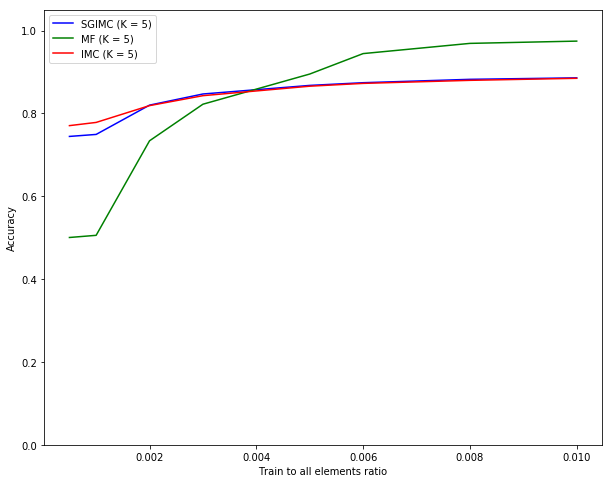

In [10]:
accuracies_sgimc = np.load(exp_path + 'results_sgimc_accuracies.npy')
accuracies_mf = np.load(exp_path + 'results_mf_accuracies.npy')
accuracies_imc = np.load(exp_path + 'results_imc_accuracies.npy')

plt.figure(figsize=(10,8))
plt.plot(elements, accuracies_sgimc, 'b-', label='SGIMC (K = 5)')
plt.plot(elements, accuracies_mf, 'g-', label='MF (K = 5)')
plt.plot(elements, accuracies_imc, 'r-', label='IMC (K = 5)')
plt.ylim((0,1.05))

plt.xlabel('Train to all elements ratio')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Combined matrix

In [38]:
X_comb = np.eye(len(R_full))
for i, feature in enumerate(X.T):
    X_comb[i] = feature
X_comb = X_comb.T

X_comb = sparsify_with_mask(X_comb, X_comb > 0)

In [39]:
accs = []
for n in tqdm(elements):
    
    R_train, mask = sparsify(R_full, n, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X_comb, Y, R_train, n_threads=8)
    
    C_accuracies = []
    for C_group in Cs_group:
        C_lasso = 10 * C_group
        C = (C_lasso, C_group, C_ridge)
        step_kwargs = {
            "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
            "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
            "rtol": 1e-2,           # the relative tolerance for stopping the ADMM
            "atol": 1e-4,           # the absolute tolerance
            "method": "tron",       # the method to use in Sub_0
            "n_iterations": 2,      # the number of iterations of the inner ADMM
        }

        W_0 = random_state.normal(size=(X_comb.shape[1], K))
        H_0 = random_state.normal(size=(Y.shape[1], K))

        W, H = W_0.copy(), H_0.copy()

        W, H = imc_descent(problem, W, H,
                           step_fn,                  # the inner optimization
                           step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                           n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                           n_init_iterations=0,
                           return_history=True,      # Record the evolution of the matrices (W, H)
                           rtol=1e-3,                # relative stopping tolerance for the outer iterations
                           atol=1e-5,                # absolute tolerance
                           verbose=False,            # show the progress bar
                           check_product=True,       # use the product W H' for stopping
                           )

        R_hat = get_prediction(X_comb, W, H, Y, binarize=True)
        C_accuracies.append(accuracy(R_full, R_hat, invert(mask)))

    accs.append(np.max(C_accuracies))

accs = np.array(accs)
np.save(exp_path + 'results_sgimc_accuracies_comb.npy', accs)


100%|██████████| 8/8 [15:49<00:00, 180.00s/it]


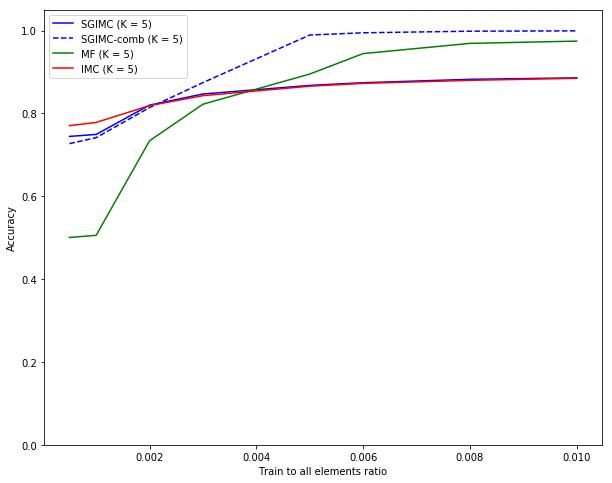

In [42]:
accuracies_sgimc = np.load(exp_path + 'results_sgimc_accuracies.npy')
accuracies_sgimc_comb = np.load(exp_path + 'results_sgimc_accuracies_comb.npy')
accuracies_mf = np.load(exp_path + 'results_mf_accuracies.npy')
accuracies_imc = np.load(exp_path + 'results_imc_accuracies.npy')

plt.figure(figsize=(10,8))
plt.plot(elements, accuracies_sgimc, 'b-', label='SGIMC (K = 5)')
plt.plot(elements, accuracies_sgimc_comb, 'b--', label='SGIMC-comb (K = 5)')
plt.plot(elements, accuracies_mf, 'g-', label='MF (K = 5)')
plt.plot(elements, accuracies_imc, 'r-', label='IMC (K = 5)')
plt.ylim((0,1.05))

plt.xlabel('Train to all elements ratio')
plt.ylabel('Accuracy')
plt.legend()

plt.show()